# Importing Packages

In [47]:
from globl import *
from functions import *
from G_file import *

import time
import numpy as np
import pandas as pd
import numpy.matlib
import datetime
import math
import scipy
import scipy.optimize as opt
import csv
import scipy.linalg
from scipy import special
import matplotlib.pyplot as pyplot
from bqplot import pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

In [48]:
Country = 'US'
FFR_file = Country + 'FFR.xlsx'
df_ffr   = pd.read_excel(FFR_file)

In [49]:
# Hyperparameters.

N                 = 2            # FIXED: Number of factors.
dTau              = 0.01         # OPTION: Spacing for TauGrid, used to numerically obtain R.
KappaP_Constraint = 'Direct'     # FIXED: KappaP matrix values are set directly, (but subject to an 
                                 # eigenvalue constraint in 'AAC_EKF_CAB_GATSM_SingleLoop'). 

ZLB_Imposed       = 1            # FIXED: 0=ANSM(2) or 1=K-ANSM(2). Meaning ZLB imposed or not
DailyIterations   = 200            # OPTION: Sets number of iterations between interim saves.
IEKF_Count        = -1e-5        # OPTION: EKF if 0, IEKF steps if >0, tolerance if <0 (e.g. -1e-5).
FinalNaturalParametersGiven = 1  # OPTION: Full estimation if 0 (the Optimization toolbox is required), 
                                 # partial estimation with given parameters if 0.
HessianRequired   = 0            # OPTION: Omits Hessian and standard errors if 0, calculates them if 1.

DataFrequency = 'Monthly'
DataFileName  = Country + '_GSW_Govt'

In [50]:
def AAH_EMS_N2_function(Phi, x_T):
    (tmp,T) = np.shape(x_T)
    ES_CAB  = np.ones((T,1)) * float('nan')
    EMS     = np.ones((T,1)) * float('nan')
    ETZ     = np.ones((T,1)) * float('nan')
    SSR     = np.sum(x_T, axis=0)
    for t in range(0, T):
        x_t = x_T[:,t]
        if (SSR[t] >= 0):
            EMS_t = -x_t[1] / Phi
        else:
            Tau0   = -np.log(-x_t[0] / x_t[1]) / Phi
            ETZ[t] = Tau0
            EMS_t  = x_t[0] * Tau0 - x_t[1] * np.exp(-Phi * Tau0) / Phi
        EMS[t] = EMS_t

    return (SSR, EMS, ETZ)

In [51]:
def AAH_EMS_N3_function(Phi, x_T, dTau):
    # Hyperparameters.
    dTau2 = 0.1 * dTau

    (tmp,T)  = np.shape(x_T)
    TauGrid  = np.matrix(np.arange(0, 100+1, dTau)).getH()
    TauGrid2 = np.matrix(np.arange(0, 1000+1, dTau2)).getH()

    EMS      = np.ones((T,1)) * float('nan')
    EMS_TauH = np.ones((T,1)) * float('nan')
    TauH     = 1
    ETZ      = np.ones((T,1)) * float('nan')
    SSR      = np.sum(x_T[0:1,:],axis=0)
    
    for t in range(0, T):
        x_t = x_T[:,t]
        E_Shadow_r = x_t[0] + x_t[1] * np.exp(-Phi*TauGrid) + x_t[2] * Phi * np.multiply(TauGrid, np.exp(-Phi*TauGrid))
        if (np.any(E_Shadow_r < 0)):
            tmp1          = np.multiply(E_Shadow_r[0:-1], E_Shadow_r[1:])
            RootIndicator = np.amax(np.where(tmp1 < 0)[0] ,axis=0)
            tmp_func      = lambda Tau0: x_t[0] + x_t[1] * np.exp(-Phi*Tau0) + x_t[2] * Phi * np.multiply(Tau0, np.exp(-Phi*Tau0))
            Tau0          = scipy.optimize.fsolve(tmp_func, np.matrix([TauGrid[RootIndicator],TauGrid[RootIndicator+1]]))
            E_Shadow_r    = x_t[0] + x_t[1] * np.exp(-Phi*TauGrid2) + x_t[2] * Phi * np.multiply(TauGrid2, np.exp(-Phi*TauGrid2))
            E_CAB_r       = np.maximum(E_Shadow_r, 0)
            dEMS          = x_t[0] - E_CAB_r
            EMS_t         = np.sum(dEMS, axis=0) * dTau2
            EMS[t]        = EMS_t
            ETZ[t]        = Tau0
            EMS_TauH_t    = np.sum(dEMS[0:TauH/dTau2],axis=0) * dTau2
            EMS_TauH[t]   = EMS_TauH_t
        else:
            EMS_t = -(x_t[1] + x_t[2]) / Phi
            EMS[t] = EMS_t
            EMS_TauH_t = -(x_t[1] + x_t[2]) * (1 - np.exp(-Phi*TauH)) / Phi + x_t[2] * np.exp(-Phi*TauH)
            EMS_TauH[t] = EMS_TauH_t

    return (SSR, EMS, ETZ)

In [52]:
def AAH_EMS_N23_function(Phi, x_T, dTau):
    (N,tmp) = np.shape(x_T)

    if (N == 2):
        (SSR, EMS, ETZ) = AAH_EMS_N2_function(Phi, x_T)
    else:
        (SSR, EMS, ETZ) = AAH_EMS_N3_function(Phi, x_T, dTau)

    return (SSR, EMS, ETZ)

In [53]:
def AAL_CommonSaveName(DataFileName, ZLB_Imposed, IEKF_Count, SampleMaturities, N, DataFrequency, FINAL, rL):
    #UNTITLED Summary of this function goes here
    #   Detailed explanation goes here

    # Time stamp for file names.
    TimeStamp = datetime.datetime.now().strftime("_%Y_%m_%d_%H_%M_%S")
    if (ZLB_Imposed == 0):
        ModelType = 'ANSM'
    else:
        ModelType = 'KANSM'

    if (FINAL == 1):
        FinalOrInterim = 'Final'
    else:
        FinalOrInterim = 'Interim'

    if (IEKF_Count < 0):
        IEKFString = "_E%.6f" % np.log10(-IEKF_Count)
    else:
        IEKFString = "%.6f" % np.log10(IEKF_Count)


    if (rL == -10):
        LowerBoundString = 'Est'
    else:
        LowerBoundString = "%.6f" % 10000 * rL


    SaveName = DataFileName + '_rL_' + LowerBoundString + '_%.6f' % SampleMaturities[-1] + '_' + ModelType + "%i" % N + '_' + DataFrequency + '_IEKF' + IEKFString + '_' + FinalOrInterim
    SaveName = SaveName + TimeStamp


    return SaveName

In [54]:
def normsdist_erf(x):
    #UNTITLED Summary of this function goes here
    #   Detailed explanation goes here

    normsdist = 0.5 * (1 + special.erf(x / numpy.sqrt(2)))

    return normsdist

In [55]:
def AAE_KAGM_f_and_df_dx(x_t, rL, KappaQ2, Sigma1, Sigma2, Rho12, TauGrid, ZLB_Imposed):
    x_t     = np.array(x_t)
    TauGrid = np.array(TauGrid)[:, 0]

    g1 = np.ones(max(np.shape(TauGrid)))
    G1 = np.copy(TauGrid)
    g2 = np.exp(-KappaQ2*TauGrid)
    G2 = (1 - g2) / KappaQ2

    # Expected path of short rate.
    SR = x_t[0] * g1 + x_t[1] * g2

    # Volatility effect.
    VE = (-0.5 * Sigma1**2 * np.multiply(G1,G1) - 
          0.5 * Sigma2**2 * np.multiply(G2,G2) - Rho12 * Sigma1 * Sigma2 * np.multiply(G1,G2))

    # Forward rate.
    GATSM_f = SR + VE

    if (ZLB_Imposed == 1):
        # Calculate annualized option volatility, Omega.
        G_11  = np.copy(TauGrid)
        G_22  = (1 - np.exp(-2*KappaQ2*TauGrid)) / (2 * KappaQ2)
        G_12  = np.copy(G2)
        Omega = np.sqrt(Sigma1**2 * G_11 + Sigma2**2 * G_22 + 2 * Rho12 * Sigma1 * Sigma2 * G_12)

        # Calculate cumulative normal probabilities for N(0,1) distribution.
        d               = np.divide(GATSM_f-rL, Omega)
        normsdist_erf_d = normsdist_erf(d)

        # Calculate gradiant and CAB_GATSM_f
        CAB_GATSM_df_dx = np.transpose(np.vstack((np.multiply(g1,normsdist_erf_d), 
                                                  np.multiply(g2,normsdist_erf_d))))
        CAB_GATSM_f     = (rL + np.multiply(GATSM_f-rL, normsdist_erf_d) + 
                           np.multiply(np.exp(-0.5*np.multiply(d,d)), Omega) / np.sqrt(2*np.pi))
    else:
        # ZLB not imposed, so just constant gradiant and GATSM_f.
        CAB_GATSM_df_dx = np.transpose(np.vstack((g1,g2)))
        CAB_GATSM_f     = np.copy(GATSM_f)

    return (CAB_GATSM_f,CAB_GATSM_df_dx)

In [56]:
def AAD_KAGM_R_and_dR_dx(x_t, rL, KappaQ2, Sigma1, Sigma2, Rho12, Tau_K, dTau, ZLB_Imposed):

    Tau_K_T = np.intp(np.round(Tau_K / dTau))

    TauMax  = np.amax(Tau_K)
    TauGrid = np.matrix(np.arange(0, TauMax+dTau*1.0e-12, dTau)).getH()

    (CAB_GATSM_f, CAB_GATSM_df_dx) = AAE_KAGM_f_and_df_dx(x_t, rL, KappaQ2, Sigma1, Sigma2, Rho12, TauGrid, 
                                                          ZLB_Imposed)

    CAB_GATSM_R     = np.matrix(np.cumsum(CAB_GATSM_f, axis=0)).getH()
    CAB_GATSM_R     = np.divide(CAB_GATSM_R, np.matrix(np.arange(1,len(CAB_GATSM_f)+1)).getH())
    CAB_GATSM_dR_dx = np.cumsum(CAB_GATSM_df_dx, axis=0)
    CAB_GATSM_dR_dx = np.divide(CAB_GATSM_dR_dx, 
                                np.matlib.repmat(
                                    np.matrix(np.arange(1,max(np.shape(CAB_GATSM_df_dx))+1)).getH(),1,2))

    # Record required results in matrix. 
    CAB_GATSM_R     = CAB_GATSM_R[Tau_K_T-1]
    CAB_GATSM_dR_dx = CAB_GATSM_dR_dx[Tau_K_T-1,:]

    return (CAB_GATSM_R,CAB_GATSM_dR_dx)

<img src="Formulas.png" />

In [57]:
def AAC_KAGM_SingleLoop(R_data, Tau_K, N, Parameters, Dt, dTau, KappaP_Constraint, ZLB_Imposed, 
                        IEKF_Count, FINAL):
    Max_IEKF_Count = 0
    Max_IEKF_Point = 0

    # Extended Kalman filter for the CAB-AFNSM(2).
    if (FINAL == 1):
        # The parameters are in their natural form, including Rho values.
#         rL      = Parameters[0]
        rL      = 0
        KappaQ2 = Parameters[1]
        KappaP  = np.matrix([[Parameters[2], Parameters[3]], [Parameters[4], Parameters[5]]])
        ThetaP  = np.matrix([[Parameters[6]], [Parameters[7]]])
        Sigma1  = np.abs(Parameters[8])
        Sigma2  = np.abs(Parameters[9])
        Rho12   = Parameters[10]
    else:
        # The parameters are in one of their restricted forms.
        if (KappaP_Constraint == 'Direct'):
#             rL      = Parameters[0]
            rL      = 0
            KappaQ2 = Parameters[1]
            KappaP  = np.matrix([[Parameters[2], Parameters[3]], [Parameters[4], Parameters[5]]])
            ThetaP  = np.matrix([[Parameters[6]], [Parameters[7]]])
            Sigma1  = np.abs(Parameters[8])
            Sigma2  = np.abs(Parameters[9])
            Rho12   = Parameters[10] / (1 + np.abs(Parameters[10]))
        else: 
            KappaQ2 = Parameters[0]
            L       = np.matrix([[Parameters[1], 0], [Parameters[2], Parameters[3]]])
            A       = np.matrix([[0, Parameters[4]], [-Parameters[4], 0]])
            KappaP  = np.matrix(L * L.getH() + A)
            ThetaP  = np.matrix([[Parameters[5]], [Parameters[6]]])
            Sigma1  = np.abs(Parameters[7])
            Sigma2  = np.abs(Parameters[8])
            Rho12   = Parameters[9] / (1 + np.abs(Parameters[9]))

    SIGMA    = np.matrix([[Sigma1, 0], [Rho12 * Sigma2, Sigma2 * np.sqrt(1 - Rho12**2)]])
    OMEGA    = SIGMA * SIGMA.getH()
    Sigma_Nu = Parameters[11:]

    (T, K)   = np.shape(R_data)
    KT       = K * T

    # Extended Kalman filter items.
    x_T = np.ones((N, T)) * float('nan')
    P_T = np.ones((N, N, T)) * float('nan')

    # Calculate the state equation quantities based on parameter values.
    D, V = np.linalg.eig(KappaP)
    d1 = D[0]
    d2 = D[1]
    if ((d1.real < 0) or (d2.real < 0)):
        if (d1.real < 0):
            d1 = 1e-6 + d1.imag * 1j
        if (d2.real < 0):
            d1 = 1e-6 + d2.imag * 1j

        D      = np.matrix(np.diag([d1, d2]))
        KappaP = np.real(np.linalg.solve(V.getH(), (V*D).getH()).getH())

    F    = np.matrix(scipy.linalg.expm(-KappaP * Dt))
    D, V = np.linalg.eig(F)
    
#     print(np.any(np.abs(D) > 1.0001))

    Q = np.matrix([[G(2 * d1,Dt), G(d1 + d2,Dt)], [0, G(2 * d2, Dt)]])
    Q = Q + np.transpose(np.triu(Q, k=1))
    # NOTE: Use TRANSPOSE, because ' gives congugate transpose.
    tmp1 = np.transpose(V)
    tmp2 = np.matrix(np.linalg.solve(V, OMEGA))
    U = np.linalg.solve(tmp1.getH(), tmp2.getH()).getH()
    Q = np.multiply(U, Q)
    Q = V * Q * np.transpose(V)
    Q = np.real(Q)

    # The measurement equation quantities depend on the state variables, and
    # so have to be re-calculated at each step of  the Kalman filter.

    # Starting the Recursion.
    # Unconditional mean and variance of state variable vector.
    x_Plus = np.copy(ThetaP)
    P_Plus = np.matrix([[0.5/d1, 1/(d1+d2)], [0, 0.5/d2]])
    P_Plus = P_Plus + np.transpose(np.triu(P_Plus, k=1))
    P_Plus = np.multiply(U, P_Plus)
    P_Plus = V * P_Plus * np.transpose(V)
    P_Plus = np.real(P_Plus)

    #IEKF_Count=2;
    logL = 0
    
    #IEKF - Iterated Extended Kalman Filter
    
    '''
    if IEKF_Count = 0, then Extended Kalman filter
    if IEKF_Count > 0, then Iterated Extended Kalman filter with fixed IEKF_Count iterations  
    if IEKF_Count < 0, then Iterated Extended Kalman filter with fixed tolerance abs(IEKF_Count) 
    '''
    
    if (IEKF_Count < 0):
        x_Tolerance = np.abs(IEKF_Count)
        IEKF_Count  = 20

    for t in range(0, T):
        # Forecast step.
        x_Minus = (np.eye(N) - F) * ThetaP + F * x_Plus
        P_Minus = F * P_Plus * F.getH() + Q

        # Update step.
        # Observations for time t.
        y_Obs     = np.matrix(0.01 * R_data[t,:]).getH()
        y_Missing = np.squeeze(np.array(np.isnan(y_Obs))) #numpy.array(numpy.isnan(y_Obs))#[:,0]
        neg_y_Missing = []
        for i in y_Missing:
            if i:
                neg_y_Missing.append(False)
            else:
                neg_y_Missing.append(True)        
        y_Obs     = y_Obs[neg_y_Missing]
        R         = np.diag(np.power(Sigma_Nu[neg_y_Missing], 2))

        x_Plus_i_Minus_1 = np.copy(x_Minus)
        x_Plus_i0        = np.copy(x_Minus)
        for i in range(1, 1 + IEKF_Count+1):
            # EKF and IEKF iterations
            # Following Simon (2006), p. 409 and pp. 411-12.
            # Note that the EKF step is the i=1 iteration. To see this, note
            # that x_Minus - x_Plus_i0 = 0 in eq. 13.64.
            # y_t_Hat=h(x_Minus,0), i.e. fitted values of y_t given x_Minus.
            # Ht=dR/dX(x_Minus), i.e. the Jacobian given x_Minus.

            (y_Hat, H_i) = AAD_KAGM_R_and_dR_dx(x_Plus_i0, rL, KappaQ2, Sigma1, Sigma2, Rho12, Tau_K, 
                                                dTau, ZLB_Imposed)

            y_Hat        = y_Hat[neg_y_Missing]
            H_i          = H_i[neg_y_Missing,:]
            HPHR_i       = (H_i * P_Minus * H_i.getH() + R)
            K_i          = np.linalg.solve(HPHR_i.getH(), (P_Minus*H_i.getH()).getH()).getH()
            w_i          = y_Obs - y_Hat - H_i * (x_Minus - x_Plus_i0)
            x_Plus_i1    = x_Minus + K_i * w_i

            if (IEKF_Count == 20):
                # Using tolerance, so check for convergence. 
                if (i > 15):
                    # Large number of iterations, so print output to screen.
                    print(t, i-1, np.matrix(x_Plus_i1).getH(), np.matrix(x_Plus_i0).getH(), 
                          np.matrix(x_Plus_i1).getH() - np.matrix(x_Plus_i0).getH())
                if (np.all(np.abs(x_Plus_i1-x_Plus_i0) < x_Tolerance)):
                    # Difference from last update within tolerance, so exit.
                    break
                if (np.all(np.abs(x_Plus_i1-x_Plus_i_Minus_1) < x_Tolerance)):
                    # Allows for numerical cycling between i+1, i, i-1 updates.
                    # Difference from i-1 update within tolerance, so exit.
                    x_Plus_i1 = 0.5 * (x_Plus_i1 + x_Plus_i0)
                    break

            # Record these values to allow testing for convergence.
            x_Plus_i_Minus_1 = np.copy(x_Plus_i0)
            x_Plus_i0        = np.copy(x_Plus_i1)

        # Calculate final posterior values and record values.
        x_Plus     = np.copy(x_Plus_i1)
        P_Plus     = (np.matrix(np.eye(N)) - K_i * H_i) * P_Minus
        x_T[:,t]   = x_Plus[:,0]
        P_T[:,:,t] = np.copy(P_Plus)
        logL       = logL + np.log(np.linalg.det(HPHR_i)) + np.linalg.solve(HPHR_i.getH(),w_i).getH() * w_i
        
        # Hold IEKF count.
        if (i-1 > Max_IEKF_Count):
            Max_IEKF_Count = i - 1
            Max_IEKF_Point = t

        # disp([num2str(t),' ',num2str(i-1),' ',num2str(x_Plus_i1'-x_Plus_i0')])
        # format long
        # str = sprintf('%s %s %3.10f',t,i,logL);
        # disp(str);
        # disp([num2str(t),' ',num2str(i-1),' ',num2str(logL)])
        # disp([num2str(t),' ',num2str(i-1),' ',sprintf('%3.16f',logL)])
        # std_SSR(t)=sqrt([1,1]*P_T(:,:,t)*[1;1]);
    #

    # log likelihood value to maximize.
    EKF_logL = -0.5 * KT * np.log(2 * np.pi) - 0.5 * logL
    # Negate the log likelihood value because fminunc minimizes.
    EKF_logL = -EKF_logL

#     print(EKF_logL*1e-3, Parameters[0:10], Rho12)

#     tmp1       = np.sum(x_T, axis=0)
#     figure     = pyplot.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w')
#     subplot    = figure.add_subplot(1,1,1, position=[0.15, 0.10, 0.75, 0.80], frame_on=True, zorder=0)
#     subplot.plot(x_T[0,:], linewidth=2, color='blue',  marker='', markersize=3, zorder=1, label="")
#     subplot.plot(x_T[1,:], linewidth=2, color='green', marker='', markersize=3, zorder=2, label="")
#     subplot.plot(tmp1,     linewidth=2, color='red',   marker='', markersize=3, zorder=3, label="")
#     pyplot.savefig("plot.pdf")
#     pyplot.show()

    return (EKF_logL, x_T)

In [58]:
def AAB_KAGM_Estimation_NelderMead(R_data, Tau_K, N, InitialParameters, Dt, dTau, KappaP_Constraint, 
                                   ZLB_Imposed, IEKF_Count, FINAL, Iterations):

    Parameters = np.copy(InitialParameters)
    
    EKF_function = lambda Parameters: AAC_KAGM_SingleLoop(R_data, Tau_K, N, Parameters, Dt, dTau, 
                                                          KappaP_Constraint, ZLB_Imposed, IEKF_Count, FINAL)[0]
    
#     FinalParameters, Fval, itera, funcalls, Exitflag, output = 
    
    genOutput = opt.fmin(func=EKF_function, x0=Parameters, xtol=float('Inf'), ftol=1e-2, 
                         maxiter=Iterations, full_output=True, disp=False)
    
#     x_T = AAC_KAGM_SingleLoop(R_data, Tau_K, N, FinalParameters, Dt, dTau, 
#                         KappaP_Constraint, ZLB_Imposed, IEKF_Count, FINAL)[1]
#     print(FinalParameters, Fval, Exitflag, output, x_T)
#     return (FinalParameters, Fval, Exitflag, output, x_T)

    print(genOutput)
    return genOutput

In [59]:
#load([DataFileName,'.mat'])
# DailyDateIndex DailyYieldCurveData Maturities MonthlyDateIndex MonthlyYieldCurveData WeeklyDateIndex WeeklyYieldCurveData

Maturities            = np.array([0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30])
sub_datenum           = datetime.date(1899,12,30).toordinal() + 366
daily_file_name       = Country + '_Daily.csv'
daily_data            = np.genfromtxt(daily_file_name, delimiter=',')

DailyDateIndex        = daily_data[:, 0].copy().astype('int')
DailyDateIndex        = DailyDateIndex.__add__(sub_datenum)
DailyYieldCurveData   = daily_data[:, 1:].copy()

weekly_file_name      = Country + '_Weekly.csv'
weekly_data           = np.genfromtxt(weekly_file_name, delimiter=',')

WeeklyDateIndex       = weekly_data[:, 0].copy().astype('int')
WeeklyDateIndex       = WeeklyDateIndex.__add__(sub_datenum)
WeeklyYieldCurveData  = weekly_data[:, 1:].copy()

month_file_name       = Country + '_Monthly.csv'
month_data            = np.genfromtxt(month_file_name, delimiter=',')

MonthlyDateIndex      = month_data[:, 0].copy().astype('int')
MonthlyDateIndex      = MonthlyDateIndex.__add__(sub_datenum)
MonthlyYieldCurveData = month_data[:, 1:].copy()

In [60]:
DailyYieldCurveData.shape, WeeklyYieldCurveData.shape, MonthlyYieldCurveData.shape

((6709, 12), (1342, 12), (310, 12))

In [61]:
FirstDay = DailyDateIndex[0]
LastDay  = DailyDateIndex[-1]
SampleMaturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 30])

In [62]:
FinalNaturalParameters_country = "FinalNaturalParameters_" + Country + ".dat"
FinalNaturalParameters         = np.loadtxt(FinalNaturalParameters_country)
InitialNaturalParameters       = np.copy(FinalNaturalParameters)
print(FinalNaturalParameters)
print("\nLenght of FinalNaturalParameters:", len(FinalNaturalParameters))

[ 1.38892800e-03  3.12788078e-01 -6.09856820e-02 -1.89000000e-05
  6.88159000e-04  7.13197100e-03  1.89715270e-02 -1.71613689e-01
  9.75263800e-03  1.36938520e-02 -7.21295197e-01  2.93863400e-03
  1.52914900e-03  3.62741000e-04  1.25527800e-03  1.29335600e-03
  9.10519000e-04  4.81851000e-04  1.35733500e-03  6.25584700e-03]

Lenght of FinalNaturalParameters: 20


In [63]:
IncludeMaturities = np.array([x in SampleMaturities for x in Maturities])
IncludeMaturities

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False, False,  True])

In [64]:
# Select the required data from the yield curve data file.

if (DataFrequency == 'Daily'):
    (StartT,) = np.where(DailyDateIndex == FirstDay)
    (EndT,)   = np.where(DailyDateIndex == LastDay)
    YieldCurveDateIndex = DailyDateIndex[StartT[0] : EndT[0]+1]
    YieldCurveData = DailyYieldCurveData[StartT[0] : EndT[0]+1,IncludeMaturities]
    Dt = (YieldCurveDateIndex[-1] - YieldCurveDateIndex[0] + 1) / (len(YieldCurveDateIndex) * 365.25)
    Iterations = np.copy(DailyIterations)
elif (DataFrequency == 'Weekly'):
    # Find earliest Friday consistent with FirstDay.
    ReferenceFriday = datetime_to_matlab_datenum(datetime.datetime.strptime('24-May-2013', "%d-%b-%Y"))
    WeeksToStepBackForStart = np.floor((ReferenceFriday - FirstDay) / 7)
    FirstWeek = ReferenceFriday - 7 * WeeksToStepBackForStart
    # Find latest Friday consistent with LastDay.
    WeeksToStepBackForEnd = 1 + np.floor((ReferenceFriday - LastDay) / 7)
    LastWeek = ReferenceFriday - 7 * WeeksToStepBackForEnd
    (StartT,) = np.where(WeeklyDateIndex==FirstWeek)
    (EndT,)   = np.where(WeeklyDateIndex==LastWeek)
    YieldCurveDateIndex = WeeklyDateIndex[StartT:EndT+1]
    YieldCurveData = WeeklyYieldCurveData[StartT:EndT+1,IncludeMaturities]
    Dt = 7 / 365.25
    Iterations = DailyIterations * 5
else:
    # Find earliest end-month consistent with FirstDay.
    [FirstYear, FirstMonth] = [datetime.datetime.fromordinal(np.int(FirstDay-366)).year, datetime.datetime.fromordinal(np.int(FirstDay-366)).month]
    if FirstMonth == 12:
        FirstYear = FirstYear+1
        FirstMonth =  0
    FirstMonth = np.int(datetime_to_matlab_datenum(datetime.datetime(FirstYear, FirstMonth+1, 1)) - 1)

    # Find latest end-month consistent with LastDay.
    [LastYear, LastMonth] = [datetime.datetime.fromordinal(np.int(LastDay-366)).year, datetime.datetime.fromordinal(np.int(LastDay-366)).month]
    if LastMonth == 12:
        LastYear = LastYear+1
        LastMonth =  0    
    LastMonth1 = np.int(datetime_to_matlab_datenum(datetime.datetime(LastYear, LastMonth+1, 1)) - 1)
    if (LastMonth1 != LastDay):
        if LastMonth == 0:
            LastYear = LastYear-1
            LastMonth =  12    
        LastMonth1 = datetime_to_matlab_datenum(datetime.datetime(LastYear, LastMonth, 1)) - 1

    (StartT,) = np.where(MonthlyDateIndex==FirstMonth)
    (EndT,)   = np.where(MonthlyDateIndex==LastMonth1)
    if ((np.size(StartT) > 0) and (np.size(EndT) > 0)):
        YieldCurveDateIndex = MonthlyDateIndex[StartT[0]:(EndT+1)[0]]
        YieldCurveData      = MonthlyYieldCurveData[StartT[0]:(EndT+1)[0],IncludeMaturities]
    else:
        YieldCurveDateIndex = np.array([])
        YieldCurveData      = np.array([])
    Dt = 1.0 / 12
    Iterations = DailyIterations * 21

In [65]:
Dt, Iterations, DailyIterations

(0.08333333333333333, 4200, 200)

In [66]:
np.matrix([[FinalNaturalParameters[2], FinalNaturalParameters[3]], 
           [FinalNaturalParameters[4], FinalNaturalParameters[5]]])

matrix([[-6.0985682e-02, -1.8900000e-05],
        [ 6.8815900e-04,  7.1319710e-03]])

In [67]:
Tau_K = np.copy(SampleMaturities)

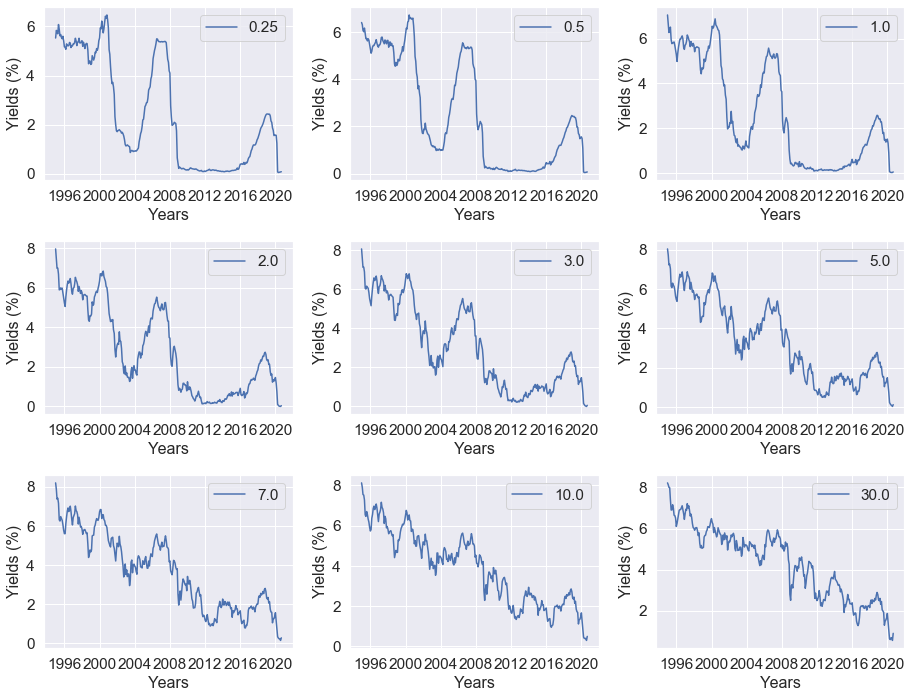

In [68]:
date_str =  [datetime.datetime.strptime(matlab_datenum_to_datetime(x).date().__str__(), '%Y-%m-%d') 
             for x in YieldCurveDateIndex]
tt = date_str
sns.set()
sns.set(font_scale = 1.4)
fig, ax = pyplot.subplots(nrows=3, ncols=3, figsize=(13, 10))

count = 0
for i in range(3):
    for j in range(3):
        sns.lineplot(x=tt, y=YieldCurveData[:, count], ax=ax[i, j], label=SampleMaturities[count])
        count += 1
        ax[i, j].set_xlabel(r"Years", fontsize=16)
        ax[i, j].set_ylabel(r"Yields (%)", fontsize=16)

fig.tight_layout()

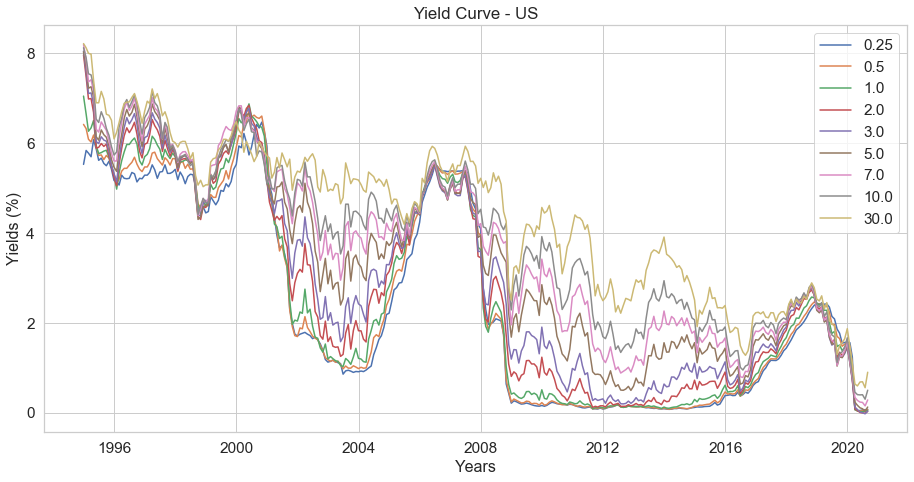

In [69]:
tt = date_str
sns.set()
sns.set(font_scale = 1.4)
sns.set_style("whitegrid")
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(13, 7))


for i in range(YieldCurveData.shape[1]):
    sns.lineplot(x=tt, y=YieldCurveData[:, i], ax=ax, label=SampleMaturities[i])

ax.set_title('Yield Curve - ' + Country)
ax.set_xlabel(r"Years", fontsize=16)
ax.set_ylabel(r"Yields (%)", fontsize=16)
fig.tight_layout()

In [70]:
# Estimation

if (FinalNaturalParametersGiven == 1):
    print('Finalizing model K-AFNSM(2) for ' + Country + " using {0}".format(Maturities[0]) + "-{0}".format(SampleMaturities[-1]) + \
          ' year data at ' + DataFrequency + ' frequency for period ' + matlab_datenum_to_datetime(YieldCurveDateIndex[0]).strftime('%d-%b-%Y') + ' to ' + \
          matlab_datenum_to_datetime(YieldCurveDateIndex[-1]).strftime('%d-%b-%Y'))
    FinalNaturalParameters = np.copy(InitialNaturalParameters)
    FINAL    = 1
    Exitflag = -1

    [Fval, x_T] = AAC_KAGM_SingleLoop(np.matrix(YieldCurveData), Tau_K, N, FinalNaturalParameters, 
                                      Dt, dTau, KappaP_Constraint, ZLB_Imposed, IEKF_Count, FINAL)

    Time0   = 0
    Time1   = 0
    Output  = 'Final parameters given'
    
    rL      = FinalNaturalParameters[0]
    KappaQ2 = FinalNaturalParameters[1]
    
    KappaP  = np.array([[FinalNaturalParameters[2], FinalNaturalParameters[3]], 
                        [FinalNaturalParameters[4], FinalNaturalParameters[5]]])
    
    ThetaP  = np.array([[FinalNaturalParameters[6]], [FinalNaturalParameters[7]]])
    Sigma1  = FinalNaturalParameters[8]
    Sigma2  = FinalNaturalParameters[9]
    Rho12   = FinalNaturalParameters[10]
    
else: # Estimate final parameters.
    print('Estimating K-AFNSM(2) for ' + Country + " using {0}".format(SampleMaturities[0]) + 
          "-{0}".format(SampleMaturities[-1]) + ' year data at ' + DataFrequency + ' frequency for period ' + 
          matlab_datenum_to_datetime(YieldCurveDateIndex[0]).strftime('%d-%b-%Y') + ' to ' + 
          matlab_datenum_to_datetime(YieldCurveDateIndex[-1]).strftime('%d-%b-%Y'))
    
    Exitflag = 0
    count = 0
#     while (Exitflag == 0):
    if (KappaP_Constraint == 'Direct'):
        InitialParameters = np.copy(InitialNaturalParameters)
        tmp_func = lambda x: x/(1 + np.abs(x)) - InitialNaturalParameters[9]
        InitialParameters[9] = opt.fsolve(tmp_func, 1)
    elif (KappaP_Constraint == 'S/A'):
        print('Nothing here.')

    # Extended Kalman filter estimation.
    Time0 = datetime_to_matlab_datenum(datetime.datetime.now())
    FINAL = 0
    Max_IEKF_Count = 0
    Max_IEKF_Point = 0

    print("started")
    genOutput = AAB_KAGM_Estimation_NelderMead(YieldCurveData[:3655, :], Tau_K, N, 
                                                        InitialParameters, Dt, dTau, KappaP_Constraint, 
                                                        ZLB_Imposed, IEKF_Count, FINAL, Iterations)

    FinalParameters, Fval, itera, funcalls, Exitflag = genOutput[0], genOutput[1], genOutput[2], genOutput[3], genOutput[4]
    x_T = AAC_KAGM_SingleLoop(YieldCurveData, Tau_K, N, FinalParameters, Dt, dTau, 
                        KappaP_Constraint, ZLB_Imposed, IEKF_Count, FINAL)[1]
    print("Ended")
    count += 1
    if (count % 50 == 0):
        print(count)
        print(type(FinalParameters))

    Time1 = datetime_to_matlab_datenum(datetime.datetime.now())

    if (KappaP_Constraint == 'Direct'):
        # Take the absolute value of Sigma parameters.
        FinalNaturalParameters = FinalParameters

        FinalNaturalParameters[8] = np.abs(FinalParameters[8])
        FinalNaturalParameters[9] = np.abs(FinalParameters[9])

        # Convert correlation parameters into correlations.
        FinalNaturalParameters[10]  = FinalParameters[10] / (1 + np.abs(FinalParameters[10]))
        FinalNaturalParameters[11:] = np.abs(FinalParameters[11:])

        # Calculate the state equation quantities based on parameter values.
        KappaQ = np.array([[0, 0], [FinalNaturalParameters[0], 0]])
        KappaP = np.array([[FinalNaturalParameters[1], FinalNaturalParameters[2]], 
                           [FinalNaturalParameters[3], FinalNaturalParameters[4]]])
        D, V = np.linalg.eig(KappaP)
        print(D)
        d1 = D[0]
        d2 = D[1]
        if ((d1.real < 0) or (d2.real < 0)):
            if (d1.real < 0):
                d1 = 1e-6 + d1.imag * 1j
            if (d2.real < 0):
                d2 = 1e-6 + d2.imag * 1j

            D = np.diag([d1, d2])
            tmp1 = np.matrix(V)
            tmp2 = tmp1 * np.matrix(np.reshape(D, (len(D),1)))

            KappaP = np.array(np.real(np.linalg.solve(tmp1.getH(), tmp2.getH()).getH()))

            FinalNaturalParameters[2] = KappaP[0, 0]
            FinalNaturalParameters[3] = KappaP[0, 1]
            FinalNaturalParameters[4] = KappaP[1, 0]
            FinalNaturalParameters[5] = KappaP[1, 1]

    elif (KappaP_Constraint == 'S/A'):
        print('Nothing here')

    rL = FinalNaturalParameters[0]

    KappaQ2 = FinalNaturalParameters[1]

    KappaP  = np.array([[FinalNaturalParameters[2], FinalNaturalParameters[3]], 
                          [FinalNaturalParameters[4], FinalNaturalParameters[5]]])

    ThetaP  = np.array([[FinalNaturalParameters[6]], [FinalNaturalParameters[7]]])
    Sigma1  = FinalNaturalParameters[8]
    Sigma2  = FinalNaturalParameters[9]
    Rho12   = FinalNaturalParameters[10]

    print(Exitflag)
    print([Max_IEKF_Point, Max_IEKF_Count])
    print(Fval)
    print(FinalNaturalParameters[0:10])

    #plotyy(1:length(x_T),x_T',1:length(x_T),sum(x_T)')
    #pause 0.1
    # Create figure
    #     figure = pyplot.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w')

    #     subplot1 = figure.add_subplot(1,1,1, position=[0.15, 0.10, 0.75, 0.80], frame_on=True, zorder=0)
    #     tmp1 = numpy.arange(0, max(numpy.shape(x_T))+1)
    #     subplot1.plot(tmp1, x_T.getH(), linewidth=2, marker='', markersize=3, zorder=1, label="")
    #     subplot2 = subplot1.twinx()
    #     subplot1.plot(tmp1, numpy.sum(x_T).getH(), linewidth=2, marker='', markersize=3, zorder=1, label="")
    #     SaveName = AAL_CommonSaveName(DataFileName, ZLB_Imposed, IEKF_Count, SampleMaturities, N, 
    # DataFrequency, 
    #.                                  FINAL, -10)
    #     disp(SaveName)

    #     figure1 = pyplot.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w')
    #     figure1.plot(tmp1, x_T.getH(), linewidth=2, marker='', markersize=3, zorder=1, label="")
    #     # Save final output in CSV file.
    #     NaturalParameterStandardErrors = -9.999 * numpy.ones(numpy.size(FinalNaturalParameters))
    #     numpy.savetxt(SaveName+".csv", FinalNaturalParameters, fmt='%25.15e', delimiter=',', newline='\n')

    # Reset InitialNaturalParameters for next iteration.
    InitialNaturalParameters = np.copy(FinalNaturalParameters)

Finalizing model K-AFNSM(2) for US using 0.25-30.0 year data at Monthly frequency for period 30-Dec-1994 to 30-Aug-2020


/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


210 15 [[ 0.02203004 -0.03677166]] [[ 0.02213955 -0.03712938]] [[-0.00010951  0.00035772]]
210 16 [[ 0.02192721 -0.03643698]] [[ 0.02203004 -0.03677166]] [[-0.00010283  0.00033468]]
210 17 [[ 0.02183124 -0.03612574]] [[ 0.02192721 -0.03643698]] [[-9.59625423e-05  3.11237425e-04]]
210 18 [[ 0.02174231 -0.03583826]] [[ 0.02183124 -0.03612574]] [[-8.89295629e-05  2.87487247e-04]]
210 19 [[ 0.02166051 -0.0355746 ]] [[ 0.02174231 -0.03583826]] [[-8.18060099e-05  2.63656014e-04]]
210 20 [[ 0.02158582 -0.03533457]] [[ 0.02166051 -0.0355746 ]] [[-7.46858361e-05  2.40033436e-04]]


In [71]:
((InitialNaturalParameters - np.loadtxt(FinalNaturalParameters_country)) ** 2).sum()

0.0

In [72]:
HessianRequired

0

In [73]:
Output = 'Maximum number of iterations reached.'

In [74]:
# Diagnostics and output.
# Calculate Hessian and standard errors for parameters, if required.
if (HessianRequired == 1):
    # Calculate Hessian and standard errors for natural model parameters.
    FINAL = 1
    NaturalHessian = AAF_FiniteDifferenceHessian(AAC_KAGM_SingleLoop, FinalNaturalParameters, 1e-10, 
                                                 YieldCurveData, Tau_K, N, Dt, dTau, KappaP_Constraint, 
                                                 ZLB_Imposed, IEKF_Count, FINAL)
    NaturalParameterStandardErrors = numpy.sqrt(numpy.abs(numpy.diag(numpy.linalg.inv(NaturalHessian))));
else:
    NaturalParameterStandardErrors = -9.999 * numpy.ones(numpy.size(FinalNaturalParameters))
    
print(NaturalParameterStandardErrors)

[-9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999
 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999]


In [75]:
# Display output.
dTime = Time1 - Time0
print(dTime*24, 'hours (=', dTime*24*60, 'minutes)')
print(Output)
print(Exitflag)
print(Fval)
print(InitialNaturalParameters[0:10])
print(FinalNaturalParameters[0:10])
print(NaturalParameterStandardErrors[0:10])
KappaQ = np.matrix([[0,0], [0,KappaQ2]])
print(KappaP, np.linalg.eig(KappaP), KappaQ-KappaP)

(T,K) = np.shape(YieldCurveData)
Residuals = np.ones((T,K)) * float('nan')
PlotCurves = 0

0 hours (= 0 minutes)
Maximum number of iterations reached.
-1
[[-13358.7347289]]
[ 1.38892800e-03  3.12788078e-01 -6.09856820e-02 -1.89000000e-05
  6.88159000e-04  7.13197100e-03  1.89715270e-02 -1.71613689e-01
  9.75263800e-03  1.36938520e-02]
[ 1.38892800e-03  3.12788078e-01 -6.09856820e-02 -1.89000000e-05
  6.88159000e-04  7.13197100e-03  1.89715270e-02 -1.71613689e-01
  9.75263800e-03  1.36938520e-02]
[-9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999 -9.999]
[[-6.0985682e-02 -1.8900000e-05]
 [ 6.8815900e-04  7.1319710e-03]] (array([-0.06098549,  0.00713178]), array([[-9.99948973e-01,  2.77461883e-04],
       [ 1.01020188e-02, -9.99999962e-01]])) [[ 6.09856820e-02  1.89000000e-05]
 [-6.88159000e-04  3.05656107e-01]]


In [76]:
for t in range(0, T):
    YieldCurveData_t = YieldCurveData[t,:]
    (Fitted_R_t,tmp1) = AAD_KAGM_R_and_dR_dx(x_T[:,t], rL, KappaQ2, Sigma1, Sigma2, Rho12, Tau_K, dTau, 
                                             ZLB_Imposed)
    Fitted_R_t = np.reshape(np.array(Fitted_R_t), (np.size(Fitted_R_t),))

    if (PlotCurves == 1):
        figure = pyplot.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w')
        subplot = figure.add_subplot(1,1,1, position=[0.15, 0.10, 0.75, 0.80], frame_on=True, zorder=0)
        subplot.plot(Tau_K, 100*Fitted_R_t,   linewidth=2, marker='', markersize=3, zorder=1, label="")
        subplot.plot(Tau_K, YieldCurveData_t, linestyle='', linewidth=2, marker='o', markersize=3, zorder=1, 
                     label="")
        #ylim([-2 10]);
        #pause(0.3)

    Residual_t = 0.01 * YieldCurveData_t - Fitted_R_t
    Residuals[t,:] = Residual_t

/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [77]:
RMSE_Residuals = np.sqrt(np.sum(np.multiply(Residuals, Residuals)) / T)
print(np.mean(Residuals))
print(RMSE_Residuals)

Phi = KappaQ2
(SSR, EMS_Q, ETZ_Q) = AAH_EMS_N23_function(Phi, x_T, dTau)

0.0002842772173545347
0.007477090630659404


/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


In [78]:
# Save final output in MatLab file.
SaveName = AAL_CommonSaveName(DataFileName, ZLB_Imposed, IEKF_Count, SampleMaturities, N, 
                              DataFrequency, FINAL, -10);
print(SaveName)

US_GSW_Govt_rL_Est_30.000000_KANSM2_Monthly_IEKF_E-5.000000_Final_2020_11_16_21_10_03


In [79]:
# Save final output in Excel spreadsheet.
RangeName = 'A2:O%i' % (max(np.shape(YieldCurveDateIndex))+1)
print(RangeName)

A2:O310


In [80]:
SSR_pos               = SSR.copy()
SSR_pos[SSR_pos <= 0] = np.nan
# fig , ax              = pyplot.subplots()
# pyplot.plot(SSR_pos*100,linewidth=2, marker='', markersize=3, zorder=1, label="slope", color='b')


SSR_neg               = SSR.copy()
SSR_neg[SSR_neg >= 0]  = np.nan
# pyplot.plot(SSR_neg*100,linewidth=2, marker='', markersize=3, zorder=1, label="slope", color='r')

In [81]:
df_ffr.columns

Index(['Dates', 'Federal Funds Target Rate'], dtype='object')

In [82]:
# tt = date_str
# #np.arange(0, len(SSR_pos))
# sns.set()
# sns.set(font_scale = 1.4)
# fig, ax = pyplot.subplots(nrows=2, ncols=1, figsize=(13, 10))

# sns.lineplot(x=tt, y=SSR_pos*100, color='b', ax=ax[0])
# sns.lineplot(x=np.array(date_str)[np.where(SSR_neg < 0)], y=SSR_neg*100, color='r', ax=ax[0])
# # sns.lineplot(x=tt, y=SSR*100, color='k', ax=ax[0], label='Shadow Rate')
# # sns.lineplot(x=df_ffr.Dates, y=df_ffr.iloc[:, 1].values, color='k', ax=ax[0], label='Policy Rate')
# ax[0].set_title('K-ANSM(2) SSR estimate - ' + Country)
# ax[0].set_xlabel(r"Years", fontsize=16)
# ax[0].set_ylabel(r"Shadow Short Rate", fontsize=16)                    


# sns.lineplot(x=date_str[1:], y=np.diff(SSR*100), color='c', ax=ax[1])
# ax[1].set_title('Change in K-ANSM(2) SSR estimate - ' + Country)
# ax[1].set_xlabel(r"Years", fontsize=16)
# ax[1].set_ylabel(r"$\Delta$ SSR", fontsize=16)            

# fig.tight_layout()

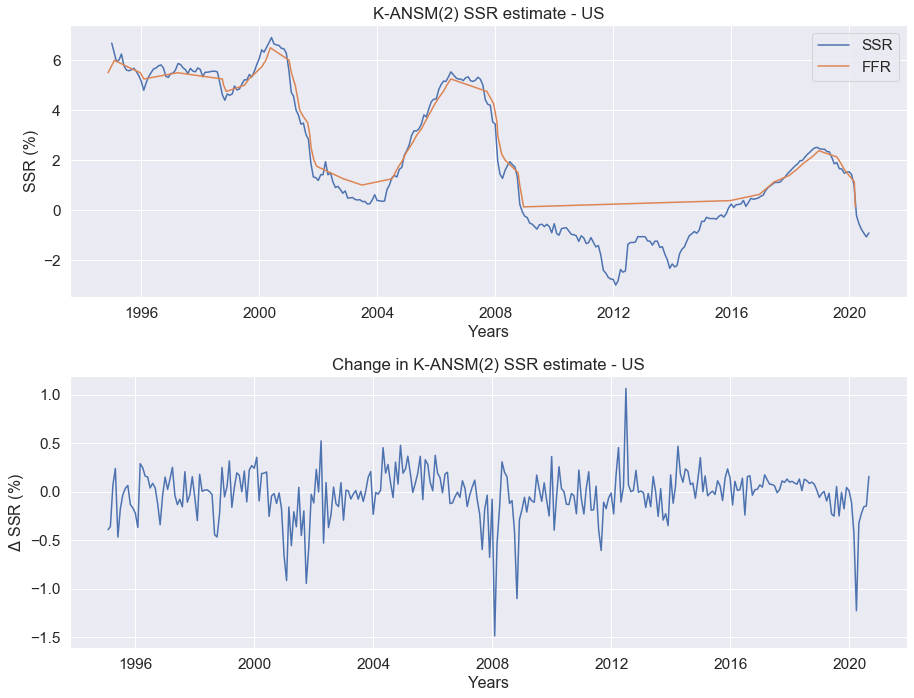

In [83]:
tt = date_str
sns.set()
sns.set(font_scale = 1.4)
fig, ax = pyplot.subplots(nrows=2, ncols=1, figsize=(13, 10))

sns.lineplot(x=tt, y=SSR*100, ax=ax[0], label='SSR')
sns.lineplot(x=df_ffr.Dates, y=df_ffr['Federal Funds Target Rate'].values, ax=ax[0], label='FFR')
ax[0].set_xlabel(r"Years", fontsize=16)
ax[0].set_ylabel(r"SSR (%)", fontsize=16)
ax[0].set_title('K-ANSM(2) SSR estimate - ' + Country)

sns.lineplot(x=tt[1:], y=np.diff(SSR*100), ax=ax[1])
ax[1].set_xlabel(r"Years", fontsize=16)
ax[1].set_ylabel(r"$\Delta$ SSR (%)", fontsize=16)
ax[1].set_title('Change in K-ANSM(2) SSR estimate - ' + Country)

fig.tight_layout()

In [84]:
# plt.clear()
# fig = plt.figure(50, title='K-ANSM(2) SSR estimate - ' + Country, background_style={'fill': 'white'})
# fig.layout.height = '350px'
# r = pd.DataFrame(date_str).set_index(0).index.values
# axes_options = {'x': {'label': 'Years', 'tick_size': 16},
#                 'y': {'label': 'SSR (%)', 'tick_size': 16}}
# plt.plot(x=r, y=SSR*100, axes_options=axes_options)
# # plt.plot(x=df_ffr.index.values, y=df_ffr['Federal Funds Target Rate'].values)
# plt.show()

# fig = plt.figure(2, title='Change in K-ANSM(2) SSR estimate - ' + Country)
# fig.layout.height = '400px'
# r = pd.DataFrame(date_str[1:]).set_index(0).index.values
# plt.plot(r, np.diff(SSR*100))
# plt.xlabel("Years", fontsize=16)
# plt.ylabel("Delta SSR (%)", fontsize=16)
# plt.show()

In [85]:
df_to_expo = pd.DataFrame(SSR)
df_to_expo['dates'] = date_str

In [86]:
loc = "/Users/akshay/Documents/Berkeley/Industry Projects/BlackRock/Leo_Krippner_SSR-TestAkshayJoshi/Results/SSR_2008Calibration2.csv"
df_to_expo.to_csv(loc)

In [87]:
# loc = "/Users/akshay/Documents/Berkeley/Industry Projects/BlackRock/Leo_Krippner_SSR-TestAkshayJoshi/Results/Params_2008Calibration2.csv"
# pd.DataFrame(InitialNaturalParameters).to_csv(loc)

In [88]:
# a  = ax.get_xticks()
# y  = [matlab_datenum_to_datetime(YieldCurveDateIndex[int(x)]).date().year for x in a[:-1]]
# pyplot.xticks(a,y, rotation=90)
# pyplot.ylabel('Percentage')
# fig.suptitle('SSR', fontsize=20)
# fig.savefig('SSR_'+ DataFrequency + '.jpg')


# fig, ax = pyplot.subplots()
# pyplot.plot(EMS_Q*100,linewidth=2, marker='', markersize=3, zorder=1, label="slope")

# a  =  ax.get_xticks()
# y  =  [matlab_datenum_to_datetime(YieldCurveDateIndex[int(x)]).date().year for x in a[:-1]] 
# pyplot.xticks(a,y, rotation=90)
# pyplot.ylabel('Percentage')
# fig.suptitle('EMS', fontsize=20)
# fig.savefig('EMS_'+DataFrequency+'.jpg')

# fig, ax = pyplot.subplots()
# pyplot.plot(ETZ_Q,linewidth=2, marker='', markersize=3, zorder=1, label="slope")

# a  =  ax.get_xticks()
# y  =  [matlab_datenum_to_datetime(YieldCurveDateIndex[int(x)]).date().year for x in a[:-1]] 
# pyplot.xticks(a,y, rotation=90)
# pyplot.ylabel('Years')
# fig.suptitle('ETZ', fontsize=20)
# fig.savefig('ETZ_'+DataFrequency+'.jpg')

# pyplot.show()

In [89]:
# output   =  np.concatenate((YieldCurveData, 100*x_T.T), axis=1)
# output   =  np.concatenate((output,  100*SSR.reshape((SSR.shape[0],1))), axis=1)
# output   =  np.concatenate((output,  100*EMS_Q.reshape((SSR.shape[0],1))), axis=1)
# output   =  np.concatenate((output,  100*ETZ_Q.reshape((SSR.shape[0],1))), axis=1)

# date_str =  [matlab_datenum_to_datetime(x).date().__str__() for x in YieldCurveDateIndex]
# k        =  np.array(date_str)
# k        =  k.reshape((len(k), 1))

# with open(SaveName+'_final.csv', 'wb') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
#     header     = ['Date']+[str(x) for x in SampleMaturities]+['Level','Slope','SSR','EMS-Q','ETZ-Q']
# #     spamwriter.writerow(header)
# #     spamwriter.writerows(map(list, zip(*np.array(header).T.tolist())))
#     for i in  range(len(date_str)):
#         data_to_write = list(k[i]) + list(output[i])
# #         spamwriter.writerow(data_to_write)
#         spamwriter.writerows(map(list, zip(*np.array(data_to_write).T.tolist())))
    
# print('Finished')

In [90]:
# file_names = ['SSR_2008Calibration2.csv', 'SSR_2014Calibration2.csv', 'SSR_FullCalibration2.csv']

# sns.set()
# sns.set(font_scale = 1.4)
# fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(13, 7))

# frames = []
# for file in file_names:
#     df = pd.read_csv("/Users/akshay/Documents/Berkeley/Industry Projects/BlackRock/Leo_Krippner_SSR-TestAkshayJoshi/Results/"+file)
#     frames.append(df['0'])
#     sns.lineplot(x=frames[-1].index, y=frames[-1].values, ax=ax, label=file)
    
# ax.set_title('Yield Curve - ' + Country)
# ax.set_xlabel(r"Years", fontsize=16)
# ax.set_ylabel(r"Yields (%)", fontsize=16) 
# fig.tight_layout()

In [91]:
# file_names = ['Params_2008Calibration2.csv', 'Params_2014Calibration2.csv', 'Params_FullCalibration2.csv']

# sns.set()
# sns.set(font_scale = 1.4)
# fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(13, 7))

# frames = []
# for file in file_names:
#     df = pd.read_csv("/Users/akshay/Documents/Berkeley/Industry Projects/BlackRock/Leo_Krippner_SSR-TestAkshayJoshi/Results/"+file)
#     frames.append(df['0'])
#     sns.lineplot(x=frames[-1].index, y=frames[-1].values, ax=ax, label=file)
    
# ax.set_title('Yield Curve - ' + Country)
# ax.set_xlabel(r"Years", fontsize=16)
# ax.set_ylabel(r"Yields (%)", fontsize=16) 
# fig.tight_layout()

In [92]:
[frames[i][0] for i in range(3)]

NameError: name 'frames' is not defined

In [ ]:
# SSR_25 = SSR
# SSR_0 = SSR
# SSR_12p5 = SSR
# SSR_100 = SSR
# SSR_m100 = SSR
# SSR_14 = SSR

In [ ]:
tt = date_str[3132:]
sns.set()
sns.set(font_scale = 1.4)
sns.set_style("whitegrid")
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(13, 7))

sns.lineplot(x=tt, y=SSR_m100[3132:]*100, ax=ax, label='-100 bps')
sns.lineplot(x=df_ffr.iloc[45:, :].Dates, y=df_ffr.iloc[45:, 1].values, ax=ax, label='FFR', color='k')
sns.lineplot(x=tt, y=SSR_0[3132:]*100, ax=ax, label='0 bps')
sns.lineplot(x=tt, y=SSR_14[3132:]*100, ax=ax, label='14 bps')
sns.lineplot(x=tt, y=SSR_25[3132:]*100, ax=ax, label='25 bps')
# sns.lineplot(x=tt, y=SSR_100*100, ax=ax, label='100 bps')
ax.set_xlabel(r"Years", fontsize=16)
ax.set_ylabel(r"SSR (%)", fontsize=16)
ax.set_title('K-ANSM(2) SSR estimate - ' + Country + ' (different lower bounds)')

fig.tight_layout()